# Learning Rate Finder 
> Automatically find optimal initial learning rate. See references.

- toc: true 
- badges: true
- comments: true
- categories: [Keras]
- image: images/chart-preview.png

## 1. Automatical learning rate finder

Step 1: We start by defining an upper and lower bound on our learning rate. The lower bound should be very small (1e-10) and the upper bound should be very large (1e+1). 
  - convergence (low lr) - divergence (high lr) 

Step 2: We then start training our network, starting at the lower bound. 
  - after each batch  we increase the learning rate --> exponentially increase
  - after each batch register/save learning rate and loss for each batch

Step 3: Training continues, and therefore the learning rate continues to increase until we hit our maximum learning rate value.
   - typically, this entire training process/learning rate increase only takes 1-5 epochs

Step 4: After training is complete we plot a smoothed loss over time, enabling us to see when the learning rate is both.

   - Just large enough for loss to decrease
   
   - And too large, to the point where loss starts to increase
   
![](images/initial_learning_rate01.png)   

![](images/initial_learning_rate02.png) 

 ## 2. Initialize NN of learning rate  using obtained lower-upper bounds
 
   - Cyclical Learning Rate policy - use both lower-upper bounds
    
   - Learning Rate Scheduele/Decay policy - use just the upper bound and decrease the learning rate as training progresses
    
 
 

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
K = keras.backend
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

In [3]:
#Import dataset
data = load_breast_cancer()
X_train, y_train = data.data, data.target 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [4]:
# construct model
input_  = tf.keras.layers.Input(shape = (X_train.shape[1],))
hidden1 = tf.keras.layers.Dense(units = 10, activation = "relu")(input_)
hidden2 = tf.keras.layers.Dense(units = 10, activation = "relu")(hidden1)
output  = tf.keras.layers.Dense(units = 2, activation = "sigmoid")(hidden2)
model   = tf.keras.Model(inputs = [input_], outputs = [output])

optimizer = tf.keras.optimizers.SGD()
model.compile(loss = tf.keras.losses.MeanSquaredError(), optimizer = optimizer)

In [5]:
class showLR(keras.callbacks.Callback) :
    def on_batch_begin(self, batch, logs=None):
        lr = float(K.get_value(self.model.optimizer.lr))
        print (" batch={:02d}, lr={:.5f}".format( batch, lr ))
        return lr

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [18]:
def learning_rate_finder(model, X_train, y_train, epochs, batch_size, min_rate, max_rate):
    # get weights that were used to initialize model
    init_weights = model.get_weights()
    # get and save initial leraning rate of model
    init_lr = K.get_value(model.optimizer.lr)
    # iterations = steps_per_epoch
    iterations =  epochs * len(X_train)/(batch_size) # steps_per_epoch
    # factor for computing expoenetial growth
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    # at batch = 0 set the learning rate at min_rate
    K.set_value(model.optimizer.lr, min_rate)
    # at each computed batch = 1,2,3, ... increase the learning rate by exponential growth
    exp_lr = ExponentialLearningRate(factor)
    # fit model
    history = model.fit(X_train, y_train, epochs=1, batch_size = batch_size, callbacks=[exp_lr, showLR()])
    return exp_lr.rates, exp_lr.losses

rates, losses = learning_rate_finder(model, X_train, y_train, epochs=1, batch_size=12, min_rate=0.05, max_rate = 100)

 batch=00, lr=0.05000
 1/48 [..............................] - ETA: 0s - loss: 0.1667 batch=01, lr=0.05869
 batch=02, lr=0.06890
 batch=03, lr=0.08088
 batch=04, lr=0.09494
 batch=05, lr=0.11144
 batch=06, lr=0.13082
 batch=07, lr=0.15357
 batch=08, lr=0.18026
 batch=09, lr=0.21161
 batch=10, lr=0.24840
 batch=11, lr=0.29158
 batch=12, lr=0.34228
 batch=13, lr=0.40179
 batch=14, lr=0.47165
 batch=15, lr=0.55365
 batch=16, lr=0.64991
17/48 [=========>....................] - ETA: 0s - loss: 0.2132 batch=17, lr=0.76290
 batch=18, lr=0.89554
 batch=19, lr=1.05124
 batch=20, lr=1.23401
 batch=21, lr=1.44856
 batch=22, lr=1.70042
 batch=23, lr=1.99606
 batch=24, lr=2.34310
 batch=25, lr=2.75048
 batch=26, lr=3.22868
 batch=27, lr=3.79003
 batch=28, lr=4.44898
 batch=29, lr=5.22250
 batch=30, lr=6.13050
 batch=31, lr=7.19637
 batch=32, lr=8.44755
33/48 [===================>..........] - ETA: 0s - loss: 0.2462 batch=33, lr=9.91627
 batch=34, lr=11.64034
 batch=35, lr=13.66417
 batch=36, lr=16.

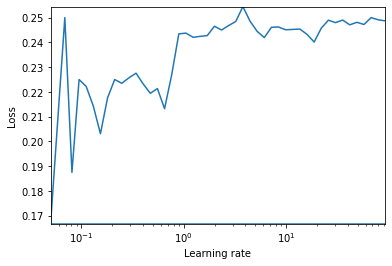

In [19]:
#plot_lr_vs_loss(rates, losses)
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), max(losses)])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.show()
plot_lr_vs_loss(rates, losses)

## References

> Adrian Rosebrock, OpenCV Face Recognition, PyImageSearch, https://www.pyimagesearch.com/, accessed on 3, January, 2021


> https://www.pyimagesearch.com/2019/08/05/keras-learning-rate-finder/